# Visualization of activation layers

This notebook displays the channels of the first activation layer of the binary classification CNN network. By examining the activations, it can be determoned which features the network learns by comparing areas of activation with the original image. In order for the notebook to run properly on this machine, it was necessary to reduce image size from 128 x 128 pixels to 64 x 64 pixels. 

### prepare data

In [1]:
# imports
import pandas as pd
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import regularizers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow.keras as keras
import PIL.Image as Image
import math
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
train_data_dir = 'data/short'

# Get all the data in the directory data/short
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=1500)

# Create the datasets
train_images, y_train = next(train_generator)


Found 1500 images belonging to 5 classes.


### Binary labeling

Label the data as belonging to one of 2 classes, healthy or diseased. 

In [62]:
# make dataframe and preview
df = pd.DataFrame(y_train)
df.head()

,0,1,2,3,4
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0


In [63]:
# add column for diseased and healthy
df.loc[df[4]==1,"Healthy"]=1
df.loc[df[4]==0,"Healthy"]=0
df.loc[df[4]==1,"Diseased"]=0
df.loc[df[4]==0,"Diseased"]=1
df.head()

,0,1,2,3,4,Healthy,Diseased
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [64]:
#drop other columns and preview
df.drop([0, 1, 2, 3, 4], axis=1, inplace=True)
df.head()

,Healthy,Diseased
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [65]:
# check for any null entries
df.isnull().sum()

Healthy     0
Diseased    0
dtype: int64

In [66]:
df['Healthy'].sum()


300.0

In [67]:
df['Diseased'].sum()


1200.0

In [12]:
# train-test plit
cnn_binary_train, cnn_binary_test, cnn_binary_train_labels, cnn_binary_test_labels= train_test_split(train_images, 
                                                                                                     df,
                                                                                                     test_size=0.2,
                                                                                                     random_state=42,
                                                                                                     shuffle=True)

In [13]:
# instantiate and train model
np.random.seed(42)
binary_cnn_model = models.Sequential()
binary_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64, 64, 3))) 
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Flatten())
binary_cnn_model.add(layers.Dense(64, activation='relu'))
binary_cnn_model.add(layers.Dense(2, activation='softmax'))

binary_cnn_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])
binary_cnn_results = binary_cnn_model.fit(cnn_binary_train,
                            cnn_binary_train_labels,
                            epochs=10,
                            batch_size=16,
                            validation_data=(cnn_binary_test, cnn_binary_test_labels))

Epoch 1/10
75/75 [==============================] - 10s 77ms/step - loss: 2.3432 - auc: 0.7618 - acc: 0.7667 - val_loss: 0.5019 - val_auc: 0.8462 - val_acc: 0.8033
Epoch 2/10
75/75 [==============================] - 5s 64ms/step - loss: 0.4891 - auc: 0.8415 - acc: 0.7975 - val_loss: 0.4799 - val_auc: 0.8453 - val_acc: 0.8000
Epoch 3/10
75/75 [==============================] - 5s 69ms/step - loss: 0.4316 - auc: 0.8855 - acc: 0.8025 - val_loss: 0.4701 - val_auc: 0.8546 - val_acc: 0.8000
Epoch 4/10
75/75 [==============================] - 4s 59ms/step - loss: 0.4272 - auc: 0.8855 - acc: 0.8108 - val_loss: 0.5170 - val_auc: 0.8268 - val_acc: 0.7700
Epoch 5/10
75/75 [==============================] - 5s 65ms/step - loss: 0.4346 - auc: 0.8799 - acc: 0.7992 - val_loss: 0.5552 - val_auc: 0.8140 - val_acc: 0.7667
Epoch 6/10
75/75 [==============================] - 5s 68ms/step - loss: 0.4104 - auc: 0.8978 - acc: 0.8308 - val_loss: 0.4774 - val_auc: 0.8643 - val_acc: 0.7867
Epoch 7/10
75/75 [===

## visualize activation channels

In [ ]:
# define outputs and an activation model
layer_outputs = [layer.output for layer in binary_cnn_model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=binary_cnn_model.input, outputs=layer_outputs)


#### View third channel of first activation layer

47/47 [==============================] - 3s 59ms/step
(1500, 62, 62, 32)


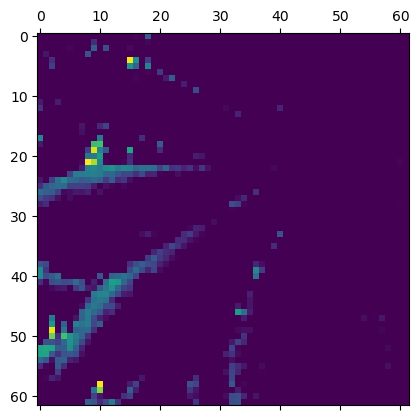

In [20]:
# Returns an array for each activation layer
activations = activation_model.predict(train_images)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

#### view 30th channel of first activation layer

47/47 [==============================] - 3s 53ms/step
(1500, 62, 62, 32)


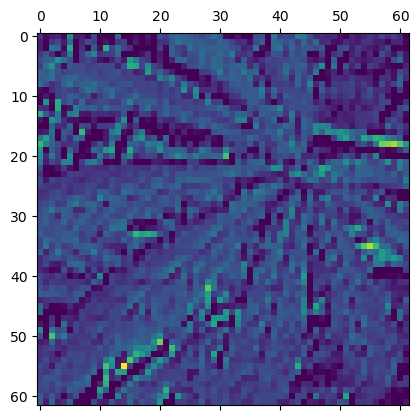

In [21]:
# Repeating the process for another channel (the 30th)
activations = activation_model.predict(train_images)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')
plt.show()

## view all channels of the first activation layer

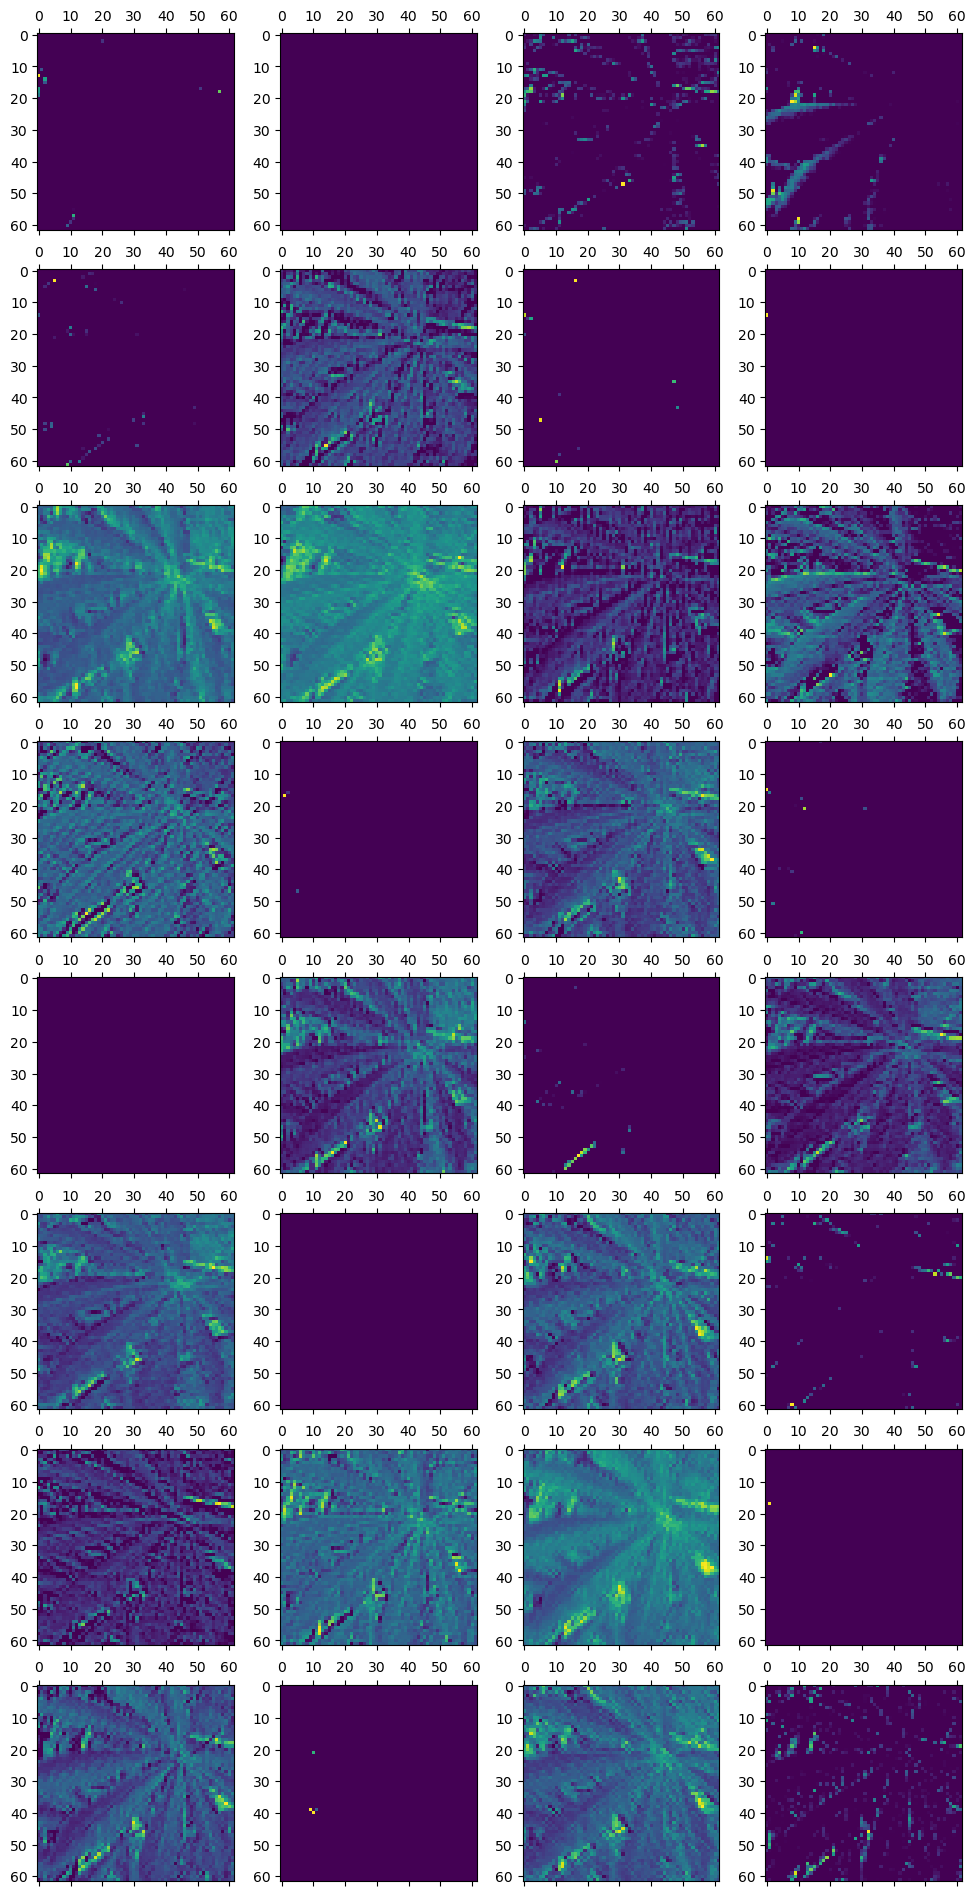

In [22]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

For this model it appears that many of the layers were paying attention to the center of the plant and the soil/litter below the plant. 